In [1]:
import os
import warnings
import shutil
warnings.filterwarnings(action='ignore')


import math
#import pandas as pd
#import librosa
#import librosa.display
import glob
import numpy as np
#import seaborn as sns; sns.set(style='whitegrid')

import random
import time

from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from sklearn.dummy import DummyClassifier
from PIL import Image
from tqdm import tqdm,tnrange,tqdm_notebook
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tensorflow.keras import backend as K 
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import applications as app
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,AveragePooling2D#, CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetB4, ResNet50, ResNet101, VGG16, MobileNet, InceptionV3, EfficientNetB2, densenet, ConvNeXtTiny
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt


2023-07-28 18:19:18.543242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device

def set_device_tf():    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only use the first GPU
      try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print(gpus[0])
      except RuntimeError as e:
        # Visible devices must be set at program startup
        print(e)
    else:
      print("No GPUs found")

#  Plotting function.
def plot_accuracy_and_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training')
  plt.plot(val_acc, label='Validation')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1.05])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training')
  plt.plot(val_loss, label='Validation')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([np.min(np.concatenate((val_loss,loss)))-0.1,np.max(np.concatenate((val_loss,loss)))+0.1])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()
  plt.close('all')

In [3]:
set_device_tf()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# Data loading.
def load_data(train_dir, test_dir):
  BATCH_SIZE = 32 # 64 can fill up GPU memory!
  IMG_SIZE = (224, 224)
  AUTOTUNE = tf.data.AUTOTUNE
    
  if train_dir is not None:
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  shuffle=True,
                                                                  validation_split=.2, ##RECENT CHANGE
                                                                  seed=123,
                                                                  subset='training',
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)

    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  shuffle=True,
                                                                  validation_split=.2, ##RECENT CHANGE
                                                                  seed=123,
                                                                  subset='validation',
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
    print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
  else:
    train_dataset = None
    validation_dataset = None
        
  if test_dir is not None:
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  shuffle=False,
                                                                  image_size=IMG_SIZE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

  else:
    test_dataset = None

  return train_dataset, validation_dataset, test_dataset


In [5]:
def compute_weights(train_dataset, validation_dataset):
  num_fails = 0
  num_passes = 0
  for images, labels in train_dataset:
      labels_np = labels.numpy()
      passes = np.count_nonzero(labels_np)
      num_passes = num_passes + passes
      fails = len(labels_np) - passes
      num_fails = num_fails + fails
      
  total = num_fails + num_passes
  print('Train Examples:\n    Total: {}\n, Passes: {}, Fails: {} ({:.2f}% of total)\n'.format(
      total, num_passes, num_fails, 100 * num_fails / total))

  # Class weights
  weight_for_fail = (1 / num_fails) * (total / 2.0)
  weight_for_passes = (1 / num_passes) * (total / 2.0)

  class_weights = {0: weight_for_fail, 1: weight_for_passes}

  print('Weight for class 0 (Fail): {:.2f}'.format(weight_for_fail))
  print('Weight for class 1 (Pass): {:.2f}'.format(weight_for_passes))

  # Number of validation classes
  num_fails = 0
  num_passes = 0
  for images, labels in validation_dataset:
    labels_np = labels.numpy()
    passes = np.count_nonzero(labels_np)
    num_passes = num_passes + passes
    fails = len(labels_np) - passes
    num_fails = num_fails + fails
    
  total = num_fails + num_passes
  print('Validation Examples: Total: {}\n, Passes: {}, Fails: {} ({:.2f}% of total)\n'.format(
    total, num_passes, num_fails, 100 * num_fails / total))
  
  return class_weights


In [6]:
"""
class DenseNetWithDropout(densenet.DenseNet121):
    def __init__(self, dropout_rate=0.5, *args, **kwargs):
        super(DenseNetWithDropout, self).__init__(*args, **kwargs)
        self.dropout_rate = dropout_rate

        custom_layers = []

        # Iterate through base model layers
        for layer in self.layers:
            custom_layers.append(layer)

            # Add dropout layer after each transition block
            if isinstance(layer, layers.MaxPooling2D):
                custom_layers.append(layers.Dropout(self.dropout_rate))

        self.layers = custom_layers
"""

'\nclass DenseNetWithDropout(densenet.DenseNet121):\n    def __init__(self, dropout_rate=0.5, *args, **kwargs):\n        super(DenseNetWithDropout, self).__init__(*args, **kwargs)\n        self.dropout_rate = dropout_rate\n\n        custom_layers = []\n\n        # Iterate through base model layers\n        for layer in self.layers:\n            custom_layers.append(layer)\n\n            # Add dropout layer after each transition block\n            if isinstance(layer, layers.MaxPooling2D):\n                custom_layers.append(layers.Dropout(self.dropout_rate))\n\n        self.layers = custom_layers\n'

In [7]:
# Create the base model from the pre-trained model MobileNet V2
def get_model(training=False, base_learning_rate = 0.0001, IMG_SIZE = (224, 224), model_type = ''):
    IMG_SHAPE = IMG_SIZE + (3,)

    ## Densenet, convnext, resnet50

    base_model_trainable = True

    if model_type != "custom":
        if model_type == "mobilenet":
            ## MOBILENETV2
            base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                          include_top=False,
                                                          weights='imagenet')
            preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        elif model_type == "resnet":
            ## RESNET50
            base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                                          include_top=False,
                                                        weights='imagenet')
            preprocess_input = tf.keras.applications.resnet50.preprocess_input
            fine_tune_at = 175 - 19
        
        elif model_type == "densenet":
            ## Densenet
            base_model = tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                                          include_top=False,
                                                        weights='imagenet')
            preprocess_input = tf.keras.applications.densenet.preprocess_input
            fine_tune_at = 427 - 20 #52 #427- 35 #427 - 20
        elif model_type == "densenet with dropout":
            ## Densenet
            base_model = DenseNetWithDropout(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
            preprocess_input = tf.keras.applications.densenet.preprocess_input
            fine_tune_at = 300
        elif model_type == "vgg16":
            ## Vgg16
            base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                        include_top=False,
                                                      weights='imagenet')
            preprocess_input = tf.keras.applications.vgg16.preprocess_input
        elif model_type == "convnexttiny":
            print("CONVNEXT SELECTED")
            # convnexttiny
            base_model = ConvNeXtTiny(input_shape=IMG_SHAPE,
                                      include_top=False,
                                      weights='imagenet')
            preprocess_input = tf.keras.applications.convnext.preprocess_input
            fine_tune_at = 132 #132 #was 132


        #image_batch, label_batch = next(iter(train_dataset))
        #feature_batch = base_model(image_batch)
        print("Number of layers = " + str(len(base_model.layers)))
        
       
        if base_model_trainable:
            base_model.trainable = True
            base_learning_rate = base_learning_rate/10
        
            # Fine-tune from this layer onwards 
            print("Number of layers = " + str(len(base_model.layers)))

            # Freeze all the layers before the `fine_tune_at` layer
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
        else:
             base_model.trainable = False
        
        
        """
        # Set the starting point for fine-tuning
        base_model.trainable = True
        fine_tune_at = None
        base_learning_rate = base_learning_rate/100
        for i, layer in enumerate(base_model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D) and layer.name.endswith("conv5_block1_1_conv"):
                fine_tune_at = i
                break
        
        print("Starting fine tuning at layer = " + str(fine_tune_at))
        if fine_tune_at:
            # Unfreeze all layers from the fine-tuning starting point
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
        else:
            print("Fine-tuning starting point not found")
         """
       
    

        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        #feature_batch_average = global_average_layer(feature_batch)
        #print(feature_batch_average.shape)

        prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
        #prediction_batch = prediction_layer(feature_batch_average)
        #print(prediction_batch.shape)


        inputs = tf.keras.Input(shape=(224, 224, 3))
        x = preprocess_input(inputs)
        x = base_model(x, training=False) #was training=False
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(0.8)(x, training=training)
        outputs = prediction_layer(x)
        model = tf.keras.Model(inputs, outputs)


    elif model_type == "custom":
        model = tf.keras.Sequential([
          tf.keras.layers.Rescaling(1./255),
          tf.keras.layers.Conv2D(12, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Conv2D(24, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Conv2D(48, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          tf.keras.layers.Dropout(0.6),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy']) # recent change - added weight decay, subsequently removed , weight_decay=0.0005


    return model

In [8]:
def get_test_model(model_type):
  test_model = get_model(training=False, model_type=model_type)
  test_model.load_weights("Weights/" + model_type + ".h5")

  return test_model

def get_performance(model, test_dataset):
  test_model = get_test_model(model)
  loss, accuracy = test_model.evaluate(test_dataset)
  print('Test accuracy :', accuracy)
  return accuracy

def predict_on_dataset(model, dataset):
    labels = []
    predictions = []

    for images, image_labels in dataset:
        preds = model.predict(images)
        predictions.extend(preds)
        labels.extend(image_labels.numpy())

    return np.array(labels).flatten(), np.array(predictions).flatten()

In [9]:
#Plotting functions
def plot_image_classifications(validation_dataset):
  class_names = ["Fail", "Pass"]

  image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch).flatten()

  # Apply a sigmoid since our model returns logits
  predictions = tf.nn.sigmoid(predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)

  print('Predictions:\n', predictions.numpy())
  print('Labels:\n', label_batch)
  print(predictions.numpy() - label_batch)

  plt.figure(figsize=(10, 10))
  start = 0
  stop = 10
  for i in range(start,stop):
    ax = plt.subplot(4, 5, i - start + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("True: " + class_names[label_batch[i]] + '\n' + "Pred: " + class_names[predictions[i]])
    plt.axis("off")


def calculate_metrics(labels, predicted_classes, class_of_interest=0):

    # Get confusion matrix
    cm = confusion_matrix(labels, predicted_classes)

    # Get values for class of interest
    TP = cm[class_of_interest, class_of_interest]
    FP = np.sum(cm[:, class_of_interest]) - TP
    FN = np.sum(cm[class_of_interest, :]) - TP
    TN = np.sum(cm) - TP - FP - FN

    # Calculate metrics
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = precision_score(labels, predicted_classes, pos_label=class_of_interest)
    recall = recall_score(labels, predicted_classes, pos_label=class_of_interest)

    print("Sensitivity = " + str(sensitivity))
    print("Specificity = " + str(specificity))
    print("Precision = " + str(precision))
    print("Recall = " + str(recall))

    return sensitivity, specificity, precision, recall
    
def plot_confusion_matrix(label_batch, predictions, class_names, save_path):
  predictions = tf.convert_to_tensor(predictions, dtype=tf.float32) # Convert to tensor  
  predictions = tf.where(predictions < 0.5, 0, 1)
  cm = confusion_matrix(label_batch, predictions.numpy() , normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot()
  plt.savefig(save_path, facecolor='white', dpi=300,
              transparent=False)
  plt.show()
  plt.close('all')

def plot_roc(label_batch, predictions, save_path):
  fp, tp, _ = roc_curve(label_batch, predictions)

  plt.plot(100*fp, 100*tp, label="ROC", linewidth=2)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  #plt.savefig(save_path + 'roc.png', facecolor='white', dpi=300,
  #            transparent=False)
  plt.show()
  plt.close('all')

def get_performance_metrics(labels, predictions):
  auc = roc_auc_score(labels, predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)
  print('Auc: %.3f' % auc)
  precision = precision_score(labels, predictions, pos_label=0, average='binary')
  recall = recall_score(labels, predictions, pos_label=0, average='binary')
  f1 = f1_score(labels, predictions, pos_label=0, average='binary')
  print('Precision: %.3f, Recall: %.3f, F-Score: %.3f,' % (precision, recall, f1))
  print(classification_report(labels, predictions))

In [10]:
densenet_model = get_test_model('densenet')
convnexttiny_model = get_test_model('convnexttiny')

Number of layers = 427
Number of layers = 427
CONVNEXT SELECTED
Number of layers = 151
Number of layers = 151


In [11]:
top_dir = "../Audio Data/Data/"
rootdir = top_dir + "Fold 0/Test/"
results = []
participant_labels = []
participant_predictions = []
concat_labels = []
concat_predictions = []
concat_predict_score_mean = []
fold_labels = []
prob_avg = []
output_avg = []
tic = time.time()
for subdir, dirs, files in os.walk(rootdir):
    for dir in dirs:
        print(rootdir + dir)
        _, _, test_dataset = load_data(None, rootdir + dir)
        #corrected_labels, corrected_predictions_resnet = predict_on_dataset(resnet_model, test_dataset)
        corrected_labels, corrected_predictions_densenet = predict_on_dataset(densenet_model, test_dataset)
        _, corrected_predictions_convnexttiny = predict_on_dataset(convnexttiny_model, test_dataset)

        print(corrected_predictions_densenet)
        corrected_predictions = np.transpose(np.vstack((#np.array(corrected_predictions_resnet), 
                                             np.array(corrected_predictions_densenet),
                                             np.array(corrected_predictions_convnexttiny))))
        print(np.shape(corrected_predictions))
        print(corrected_predictions)
        corrected_predictions = np.mean(corrected_predictions, axis=1) # np.sqrt(np.multiply(corrected_predictions[:, 0], corrected_predictions[:,1])) 
        print(corrected_predictions)
        print(np.shape(corrected_predictions))

        concat_labels = np.concatenate((concat_labels, corrected_labels), axis=0)
        
        print("Concat labels shape")
        print(np.shape(concat_labels))

        concat_predictions = np.concatenate((concat_predictions, corrected_predictions), axis=0)
        print("Concat predictions shape")
        print(np.shape(concat_predictions))
        predict_on_performance = 1-(np.count_nonzero(tf.where(corrected_predictions < 0.5, 0, 1) - corrected_labels))/len(corrected_labels)
        predict_score_mean = np.mean(corrected_predictions)
        concat_predict_score_mean.append(predict_score_mean)        

        print("Labels " + str(corrected_labels))
        print("Predictions = " + str(tf.where(corrected_predictions < 0.5, 0, 1).numpy()))
        print("Label length = " + str(len(corrected_labels)))
        print("Predictions length = " + str(len(corrected_predictions)))
        print("Model performance (predict_on) " + str(predict_on_performance))
        print("Prediction cumulative score = " + str(predict_score_mean))
        #get_performance(model, test_dataset)
        results.append(predict_on_performance)
        prob_avg.append(np.mean(corrected_predictions))
        output_avg.append(np.mean(tf.where(corrected_predictions < 0.5, 0, 1)))
        
        participant_labels.append(corrected_labels[0])
        print(participant_labels)
        participant_predictions.append(0 if predict_on_performance < 0.5 else 1)

        first_pass = False

        print("Elapsed time = " + str(time.time() - tic))
    break

../Audio Data/Data/Fold 0/Test/Test Participant 1
Found 91 files belonging to 2 classes.
1/1 [==============================] - 4s 4s/step
[0.34694877 0.7086585  0.47311053 0.6742392  0.3763719  0.55967057
 0.3213767  0.22622679 0.15597229 0.5196325  0.2984193  0.5215833
 0.35168475 0.75135875 0.6338399  0.50102973 0.28147697 0.60470295
 0.6497219  0.70617384 0.84268093 0.8384421  0.5873422  0.40837845
 0.63546795 0.5686535  0.5284508  0.60442185 0.71669155 0.64295495
 0.51067764 0.30497146 0.19789943 0.3113593  0.09498639 0.49549615
 0.514917   0.52211595 0.49186602 0.30899036 0.13410784 0.6146622
 0.58826566 0.6935805  0.42007604 0.45165294 0.5431171  0.28211248
 0.34371203 0.21227008 0.2504452  0.1748549  0.2233863  0.45665082
 0.35245523 0.12939063 0.2422921  0.378827   0.63716555 0.56948805
 0.49518633 0.4448102  0.23117204 0.47311127 0.50412184 0.70798355
 0.25941864 0.29027638 0.3616864  0.3654912  0.56313777 0.5951519
 0.43237016 0.32774267 0.22919086 0.18179175 0.62916124 0.52

## Single Clip Performance

[0.5934065934065934, 0.9714285714285714, 0.4375, 0.9111111111111111, 0.625, 1.0, 0.8169014084507042, 0.6394557823129252, 0.7796610169491526, 0.28260869565217395, 0.8924731182795699, 0.3870967741935484, 0.6799999999999999, 0.9069767441860466, 0.12, 0.9385964912280702, 0.7017543859649122, 0.9452054794520548, 0.4666666666666667, 0.20370370370370372, 0.6415094339622642, 0.125, 0.9285714285714286, 0.7954545454545454, 0.5428571428571429, 0.4871794871794872, 0.9615384615384616, 0.5775862068965517]
Overall accuracy is 0.6556872589087746
(1897,)
(1897,)


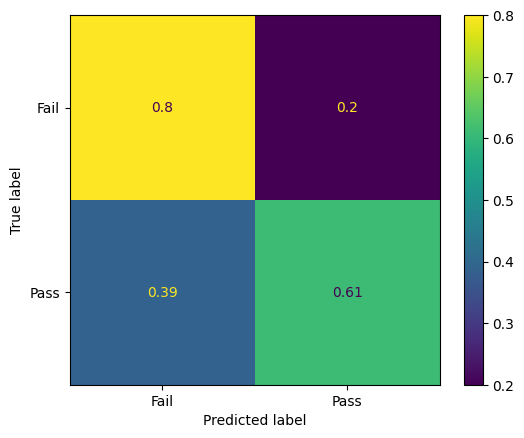

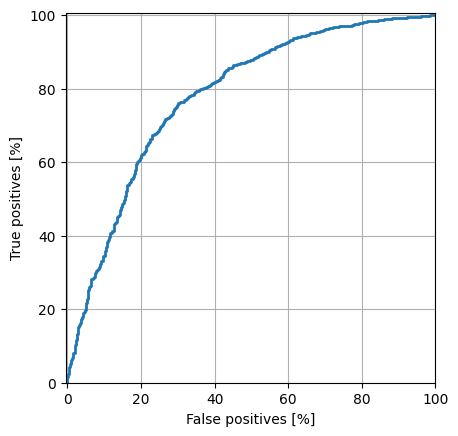

Auc: 0.782
Precision: 0.517, Recall: 0.800, F-Score: 0.628,
              precision    recall  f1-score   support

         0.0       0.52      0.80      0.63       650
         1.0       0.85      0.61      0.71      1247

    accuracy                           0.68      1897
   macro avg       0.69      0.71      0.67      1897
weighted avg       0.74      0.68      0.68      1897

[0.58082855 0.83384007 0.61528015 ... 0.26251018 0.05949133 0.18912968]
Sensitivity = 0.8
Specificity = 0.6102646351242983
Precision = 0.5168986083499006
Recall = 0.8


(0.8, 0.6102646351242983, 0.5168986083499006, 0.8)

In [12]:
#### %matplotlib inline
%matplotlib inline
print(results)
result_dict = []
class_names = ["Fail", "Pass"]
i = 0

print("Overall accuracy is " + str(np.mean(results)))
print(np.shape(concat_predictions))
print(np.shape(concat_labels))
plot_confusion_matrix(concat_labels, concat_predictions, class_names, "Result Images/clip_confusion.png")
plot_roc(concat_labels, concat_predictions,  "Result Images/clip_roc.png")
get_performance_metrics(concat_labels, concat_predictions)
print(concat_predictions)
predicted_labels = tf.where(concat_predictions < 0.5, 0, 1)

calculate_metrics(concat_labels, predicted_labels, class_of_interest=0)

# Participant Level Performance

[0.5318754, 0.7274227, 0.47408444, 0.27633575, 0.5555307, 0.101257905, 0.6534804, 0.41399541, 0.6148229, 0.38451615, 0.6950611, 0.40481514, 0.5687778, 0.68676656, 0.32312247, 0.21116483, 0.59881234, 0.22935502, 0.46971798, 0.6351814, 0.5471519, 0.29542354, 0.26046008, 0.345224, 0.49608502, 0.48522276, 0.19613948, 0.5255352]


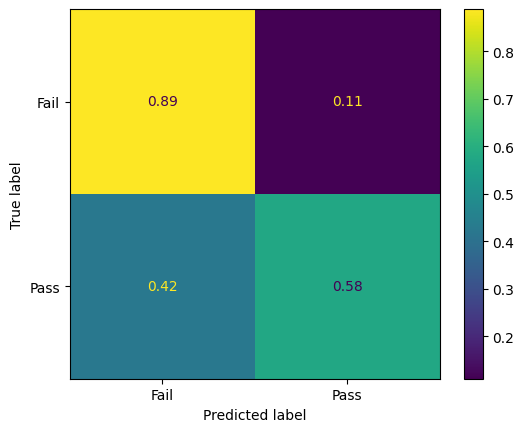

[0.5318754, 0.7274227, 0.47408444, 0.27633575, 0.5555307, 0.101257905, 0.6534804, 0.41399541, 0.6148229, 0.38451615, 0.6950611, 0.40481514, 0.5687778, 0.68676656, 0.32312247, 0.21116483, 0.59881234, 0.22935502, 0.46971798, 0.6351814, 0.5471519, 0.29542354, 0.26046008, 0.345224, 0.49608502, 0.48522276, 0.19613948, 0.5255352]
[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
[1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]


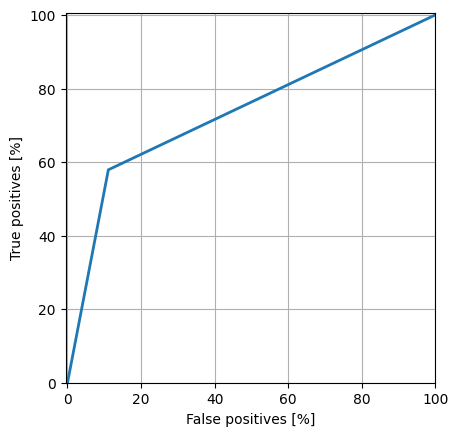

Auc: 0.877
Precision: 0.500, Recall: 0.889, F-Score: 0.640,
              precision    recall  f1-score   support

           0       0.50      0.89      0.64         9
           1       0.92      0.58      0.71        19

    accuracy                           0.68        28
   macro avg       0.71      0.73      0.67        28
weighted avg       0.78      0.68      0.69        28

Sensitivity = 0.8888888888888888
Specificity = 0.5789473684210527
Precision = 0.5
Recall = 0.8888888888888888


(0.8888888888888888, 0.5789473684210527, 0.5, 0.8888888888888888)

In [13]:
i = 0
participant_predictions = []

print(prob_avg)
for score in prob_avg: # can also use prob_avg or output_avg
    participant_predictions.append(1 if score > 0.5 else 0)
    i=i+1

plot_confusion_matrix(np.array(participant_labels), np.array(participant_predictions), class_names, "Result Images/participant_confusion.png")

print(concat_predict_score_mean)
print(participant_labels)
print(participant_predictions)
plot_roc(participant_labels, participant_predictions,  "Result Images/participant_roc.png")
get_performance_metrics(participant_labels, np.array(concat_predict_score_mean))
predicted_participant_labels = tf.where( np.array(concat_predict_score_mean) < 0.5, 0, 1)
calculate_metrics(participant_labels, predicted_participant_labels, class_of_interest=0)

# **Dummy Classifier to compare performance**


In [14]:
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(None, concat_labels)
dummy_predictions = dummy_clf.predict(np.ones((len(concat_labels),1)))
get_performance_metrics(concat_labels, dummy_predictions)

Auc: 0.500
Precision: 0.000, Recall: 0.000, F-Score: 0.000,
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       650
         1.0       0.66      1.00      0.79      1247

    accuracy                           0.66      1897
   macro avg       0.33      0.50      0.40      1897
weighted avg       0.43      0.66      0.52      1897

